## 必要な式一覧
正規分布の共分散行列が$y=0$と$y=1$で同じ場合。
$$
\begin{align}
p(x|y=0) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{0})^{T}\Sigma^{-1}(x-\mu_{0})) \\
p(x|y=1) &= \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}\exp(-\frac{1}{2}(x-\mu_{1})^{T}\Sigma^{-1}(x-\mu_{1})) \\
p(y) &= \phi^{y}(1-\phi)^{1-y} \\
\end{align}
$$

最尤推定で算出した各パラメータ。
$$
\begin{align}
\phi &= \frac{1}{m}\sum_{i=1}^{m}y^{(i)} = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\} \\
\mu_{0} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}x^{(i)}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=0\}} \\
\mu_{1} &= \frac{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}x^{(i)}}{\sum_{i=1}^{m}\mathbb{I}\{y^{(i)}=1\}} \\
\Sigma &= \frac{1}{m}\sum_{i=1}^{m}(x^{(i)}-\mu_{y^{(i)}})(x^{(i)}-\mu_{y^{(i)}})^{T} \\
\end{align}
$$

推論時にはargmaxを算出。
$$
\begin{align}
\DeclareMathOperator*{\argmax}{arg\,max} \\
\argmax_{y}p(x|y)=\argmax_{y}p(x|y)p(y) \\
\end{align}
$$

In [1]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

%matplotlib inline

In [2]:
np.random.seed(0)

### 必要なクラス・関数を定義する。

In [3]:
# GDAを実装する
class GDA:
    def fit(self, X, y):
        self.phi = np.mean(y)
        self.mu0 = np.mean([xi for xi, yi in zip(X, y) if yi == 0], axis=0)
        self.mu1 = np.mean([xi for xi, yi in zip(X, y) if yi == 1], axis=0)
        outer_prods = []
        for xi, yi in zip(X, y):
            x_minus_mu = xi - (self.mu0 if yi == 0 else self.mu1)
            outer_prods.append(np.outer(x_minus_mu, x_minus_mu))
        self.sigma = np.mean(outer_prods, axis=0)
    
    def predict_proba(self, X):
        probs = []
        for xi in X:
            prob0 = gaussian(xi, self.mu0, self.sigma) * bernoulli(0, self.phi)
            prob1 = gaussian(xi, self.mu1, self.sigma) * bernoulli(1, self.phi)
            probs.append([prob0, prob1])
        
        return probs


def gaussian(x, mu, sigma):
    """scipy.stats.multivariate_normalとほぼ同じ値が出力される"""
    num = np.e ** ((x - mu) @ np.linalg.inv(sigma) @ (x - mu) / -2)
    denom = (np.linalg.det(sigma) * (2 * np.pi) ** len(x)) ** 0.5
    return num / denom


def bernoulli(y, phi):
    return phi if y == 1 else 1 - phi

In [4]:
# 描画用関数を作成する
def plt_data(ax, X, y):
    X0 = X[y == 0]
    X1 = X[y == 1]
    ax.scatter(X0.T[0], X0.T[1], color='blue')
    ax.scatter(X1.T[0], X1.T[1], color='red')


def plt_contour(ax, mean, cov, cmap):
    N = 200
    X = np.linspace(xmin, xmax, N)
    Y = np.linspace(ymin, ymax, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean=mean, cov=cov)
    Z = rv.pdf(pos)
    ax.contour(X, Y, Z, cmap=cmap)

### データを準備する。

In [5]:
cmap0 = 'Blues'
cmap1 = 'Reds'
mean0 = np.array([2, 0])
mean1 = np.array([3, 3])
cov0 = np.array([[1, 0], [0, 1]])
cov1 = np.array([[1.2, -0.2], [-0.2, 0.8]])
size = 80

X0 = np.random.multivariate_normal(mean=mean0, cov=cov0, size=size)
y0 = np.zeros(size, dtype=np.int64)
X1 = np.random.multivariate_normal(mean=mean1, cov=cov1, size=size)
y1 = np.ones(size, dtype=np.int64)

X = np.concatenate([X0, X1], axis=0)
y = np.concatenate([y0, y1], axis=0)

xmin, xmax = X.T[0].min(), X.T[0].max()
ymin, ymax = X.T[1].min(), X.T[1].max()

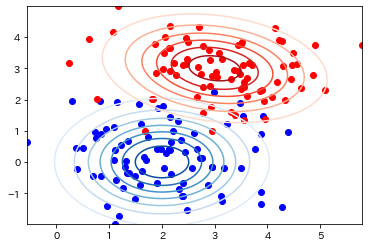

In [6]:
ax = plt.subplot(1, 1, 1)
plt_data(ax, X, y)
plt_contour(ax, mean0, cov0, cmap0)
plt_contour(ax, mean1, cov1, cmap1)

### GDAの結果を描画する。

In [7]:
gda = GDA()
gda.fit(X, y)

In [8]:
print(f'phi: {gda.phi}')
print(f'mu0: {gda.mu0}')
print(f'mu1: {gda.mu1}')
print(f'sigma:')
print(gda.sigma)

phi: 0.5
mu0: [2.01370155 0.19356015]
mu1: [3.1037893  2.91784232]
sigma:
[[ 1.09855886 -0.09519291]
 [-0.09519291  0.83140581]]


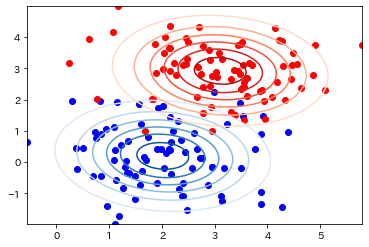

In [9]:
# 各データは異なる正規分布から抽出したが、GDAでは共分散行列が共通なので、同じ形の等高線が引かれる。
ax = plt.subplot(1, 1, 1)
plt_data(ax, X, y)
plt_contour(ax, gda.mu0, gda.sigma, cmap0)
plt_contour(ax, gda.mu1, gda.sigma, cmap1)

### 決定境界を描画する。
良い方法が見つからなかったため、描画範囲全体の点に対して推論するという力技で描画を試みる。

In [10]:
def plt_decision_boundary(ax, gda, diff=0.01, tol=0.01):
    grid = []
    for xi in np.arange(xmin, xmax, diff):
        for yi in np.arange(ymin, ymax, diff):
            grid.append([xi, yi])

    valid = []
    probs = [prob / sum(prob) for prob in gda.predict_proba(grid)]
    for (xi, yi), (prob0, prob1) in zip(grid, probs):
        if abs(prob0 - prob1) < tol:
            valid.append([xi, yi])

    valid = np.array(valid)
    ax.plot(valid.T[0], valid.T[1], color='green')

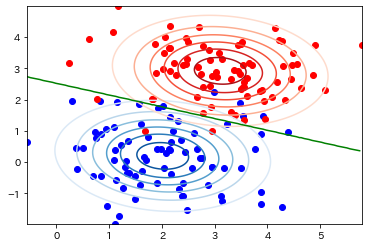

In [11]:
# 決定境界は線形になった。
ax = plt.subplot(1, 1, 1)
plt_data(ax, X, y)
plt_contour(ax, gda.mu0, gda.sigma, cmap0)
plt_contour(ax, gda.mu1, gda.sigma, cmap1)
plt_decision_boundary(ax, gda, diff=0.03)

### （おまけ）共分散行列が異なる擬似GDAを作成し、決定境界を描画する。
Andrew先生曰く、
```
Why do we use two separate means, mu0 and mu1, and a single covariance matrix, sigma?
It turns out that if you choose to build a model this way, the decision boundary ends up being linear.
It turns out you can choose to use two separate covariate matrix, sigma0 and sigma1, that will actually work OK.
It's actually very reasonable way to do so as well, but you double the number of parameters roughly, and you end up with a decision boundary that isn't linear anymore.
```
とのことで、共分散行列が共通の場合に決定境界が線形になることは上で確認したので、共分散行列が異なる場合にどうなるかを確認する。

In [12]:
# パラメーターを固定で擬似GDAを実装する
class PseudoGDA:
    def __init__(self):
        self.phi = 0.5
        self.mu0 = mean0
        self.mu1 = mean1
        self.sigma0 = cov0
        self.sigma1 = cov1

    def predict_proba(self, X):
        probs = []
        for xi in X:
            prob0 = gaussian(xi, self.mu0, self.sigma0) * bernoulli(0, self.phi)
            prob1 = gaussian(xi, self.mu1, self.sigma1) * bernoulli(1, self.phi)
            probs.append([prob0, prob1])

        return probs

In [13]:
pseudo_gda = PseudoGDA()

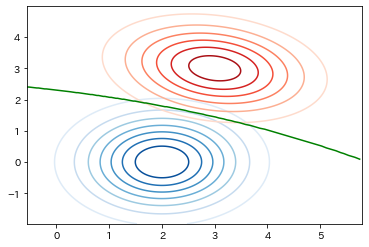

In [14]:
# 決定境界が非線形になった！！
ax = plt.subplot(1, 1, 1)
plt_contour(ax, pseudo_gda.mu0, pseudo_gda.sigma0, cmap0)
plt_contour(ax, pseudo_gda.mu1, pseudo_gda.sigma1, cmap1)
plt_decision_boundary(ax, pseudo_gda, diff=0.03)

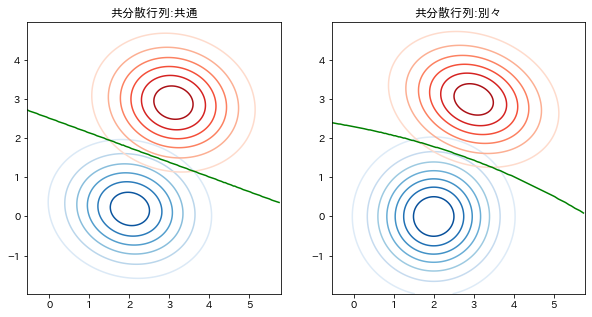

In [15]:
# 2つの結果を並べる。
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('共分散行列:共通')
plt_contour(ax1, gda.mu0, gda.sigma, cmap0)
plt_contour(ax1, gda.mu1, gda.sigma, cmap1)
plt_decision_boundary(ax1, gda, diff=0.03)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('共分散行列:別々')
plt_contour(ax2, pseudo_gda.mu0, pseudo_gda.sigma0, cmap0)
plt_contour(ax2, pseudo_gda.mu1, pseudo_gda.sigma1, cmap1)
plt_decision_boundary(ax2, pseudo_gda, diff=0.03)